## Setup

In [52]:
%run code.py
%matplotlib inline
time_all_start = datetime.now()

In [2]:
sig_file_name = 'data/all_el.root'
bkg_file_name = 'data/all_mu.root'

# data
# sig_tree  = 'electron_tags'
# bkg_tree  = 'muons'

# MC
sig_tree  = 'electron_mc'
bkg_tree  = 'muon_mc'

fit_verbose = 1

output_path = 'plots'
make_path(output_path)

## Create eProbabilityHT curves

In [3]:
el_eprob = uproot.open(sig_file_name)[sig_tree].array('eProbHT')
mu_eprob = uproot.open(bkg_file_name)[bkg_tree].array('eProbHT')

m_eprob = min(el_eprob.shape[0], mu_eprob.shape[0])
el_eprob = el_eprob[:m_eprob]
mu_eprob = mu_eprob[:m_eprob]
print('Using %.2g el, %.2g mu for eProbHT' % (el_eprob.shape[0], mu_eprob.shape[0]))

roc_eprob_obj = eprob_roc_generateor(el_eprob, mu_eprob)

roc_eprob = [roc_eprob_obj.tpr(), roc_eprob_obj.fpr(), 'eProbHT', 'eprob', 'black', '-']

Using 7.2e+05 el, 7.2e+05 mu for eProbHT


## Setup variables to train on

In [4]:
input_variables = OrderedDict([
    ('p',['$p$','default']),
    ('pT',['$p_\mathrm{T}$','default']),
    ('eta',['$\eta$','symmetric']),
    ('nTRThitsMan',['nTRT','default']),
    ('nTRTouts',['nTRT outs','default']),
    ('fHTMB',['Fraction HTMB','default']),
    ('fAr',['Fraction Ar','default']),
    ('trkOcc',['Track Occ.','default']),
    ('sumToTsumL',['$\sum\mathrm{ToT} / \sum L$','default'])
])

# other vars
# lep_pT, phi
# nTRThits, nArhits, nXehits, nHThitsMan, nPrechitsMan, NhitsdEdx, sumToT, sumL, PHF

# all the hit_ vars
# eProbHT

In [5]:
sig_df, bkg_df, X_train, X_test, Y_train, Y_test = create_df_tts_scale(
    sig_file_name, sig_tree,
    bkg_file_name, bkg_tree,
    list(input_variables),
    test_size=0.2,
    # test_size=0.333333,
    # sig_n=50000,
    # bkg_n=50000,
    shuffle=True,
    scale_style={i:v[1] for i,(_,v) in enumerate(input_variables.items())}
)

# val_data=None
val_data=(X_test, Y_test)

In [6]:
if False:
    print(X_train.shape)
    print(X_train[0])
    print(Y_train.shape)
    print(Y_train[0])
    print(X_train.shape[1])

input_ndimensions = X_train.shape[1]
leptons_m = Y_train.shape[0]

print("Training on m = %.2g leptons, n = %d input variables" % (leptons_m, input_ndimensions))

Training on m = 1.3e+06 leptons, n = 9 input variables


## Plot input variables

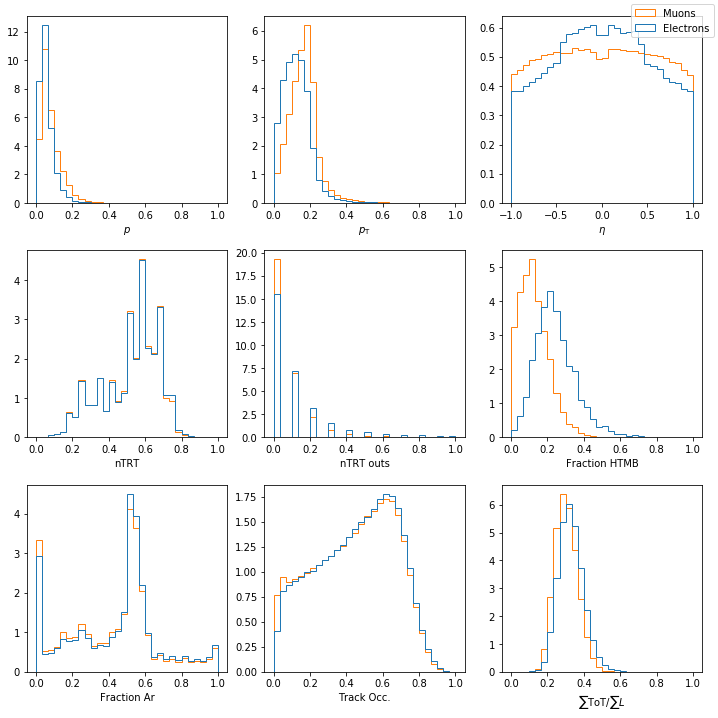

In [53]:
plot_all_input_vars(input_variables, X_train, Y_train, output_path)

In [8]:
# plot_scale_example(sig_file_name,sig_tree,output_path,'p','$p$ [GeV]'
# plot_scale_example(sig_file_name,sig_tree,output_path,'pT','$p_\mathrm{T}$ [GeV]')

## SVM (sklearn)

In [9]:
svm_m = min(50000, Y_train.shape[0])

In [10]:
fname_svm1 = 'models/svm1'
train_load_svm1 = train_or_load(fname_svm1+'.pkl')

Model NOT found on disk, training


In [11]:
if train_load_svm1 == 'n':
    
    # create
    svm1 = svm.SVC(#C=1.0, #kernel='rbf', #tol=0.001, #gamma='auto',
    probability=True,
    verbose=False);

    # train
    train_start = datetime.now()

    svm1.fit(X_train[:svm_m],Y_train[:svm_m]);

    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to pickle
    joblib.dump(svm1, fname_svm1+'.pkl');
    
else:
    # load model from pickle
    svm1 = joblib.load(fname_svm1+'.pkl');

Training time: 0 hours, 4 minutes, 27 seconds


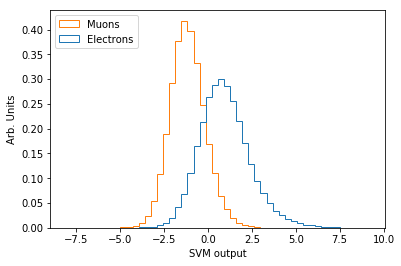

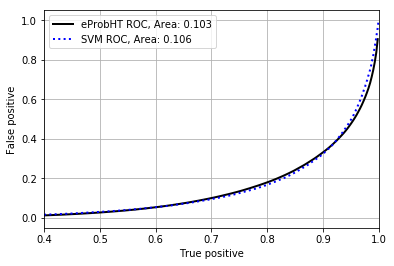

In [37]:
plot_classifier_1D_output(svm1.decision_function(X_test[Y_test>0.5]), # el
                          svm1.decision_function(X_test[Y_test<0.5]), # mu
                          'SVM', 'svm', output_path
                          #, 'Default sklearn.svm.SVC settings'
                         )

fpr_svm1, tpr_svm1, thresholds_svm1 = roc_curve(Y_test, svm1.decision_function(X_test))
roc_svm1 = [tpr_svm1, fpr_svm1, 'SVM', 'svm', 'blue', ':']

plot_roc([roc_eprob, roc_svm1], output_path)

# Keras / Tensorflow work

In [13]:
# fix random seed for reproducibility
np.random.seed(7)

from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model

/home/mbe9/.virtualenvs/trtml/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Default

In [14]:
fname_model_default = 'models/model_default'
train_load_model_default = train_or_load(fname_model_default+'.h5')

Model NOT found on disk, training


In [15]:
if train_load_model_default == 'n':
    
    # create
    model_default = Sequential()
    model_default.add(Dense(12, input_dim=input_ndimensions, activation='relu'))
    model_default.add(Dense(8, activation='relu'))
    model_default.add(Dense(1, activation='sigmoid'))

    model_default.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train
    train_start = datetime.now()
    hist_model_default = model_default.fit(X_train, Y_train,
                                           epochs=100, batch_size=50,
                                           verbose=fit_verbose, validation_data=val_data);

    hist_dict_model_default = hist_model_default.history
    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to HDF5, history to pickle
    model_default.save(fname_model_default+'.h5')
   
    with open(fname_model_default+'_hist.pickle', 'wb') as handle:
        pickle.dump(hist_dict_model_default, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    # load model from HDF5, history from pickle
    model_default = load_model(fname_model_default+'.h5')
    
    with open(fname_model_default+'_hist.pickle', 'rb') as handle:
        hist_dict_model_default = pickle.load(handle)

Train on 1339322 samples, validate on 334831 samples
Epoch 1/100
1339322/1339322 [==============================] - 30s 22us/step - loss: 0.3982 - acc: 0.8183 - val_loss: 0.3878 - val_acc: 0.8228
Epoch 2/100
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3861 - acc: 0.8238 - val_loss: 0.3885 - val_acc: 0.8229
Epoch 3/100
1339322/1339322 [==============================] - 30s 22us/step - loss: 0.3848 - acc: 0.8245 - val_loss: 0.3845 - val_acc: 0.8246
Epoch 4/100
1339322/1339322 [==============================] - 30s 22us/step - loss: 0.3843 - acc: 0.8246 - val_loss: 0.3842 - val_acc: 0.8246
Epoch 5/100
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3840 - acc: 0.8248 - val_loss: 0.3843 - val_acc: 0.8244
Epoch 6/100
1339322/1339322 [==============================] - 30s 22us/step - loss: 0.3837 - acc: 0.8249 - val_loss: 0.3829 - val_acc: 0.8257
Epoch 7/100
1339322/1339322 [==============================] - 30s 22us/step - loss: 0.38

1339322/1339322 [==============================] - 29s 21us/step - loss: 0.3809 - acc: 0.8263 - val_loss: 0.3808 - val_acc: 0.8262
Epoch 58/100
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3809 - acc: 0.8262 - val_loss: 0.3807 - val_acc: 0.8263
Epoch 59/100
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3809 - acc: 0.8262 - val_loss: 0.3819 - val_acc: 0.8257
Epoch 60/100
1339322/1339322 [==============================] - 30s 22us/step - loss: 0.3809 - acc: 0.8262 - val_loss: 0.3819 - val_acc: 0.8260
Epoch 61/100
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3808 - acc: 0.8263 - val_loss: 0.3814 - val_acc: 0.8255
Epoch 62/100
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3808 - acc: 0.8263 - val_loss: 0.3824 - val_acc: 0.8257
Epoch 63/100
1339322/1339322 [==============================] - 31s 23us/step - loss: 0.3808 - acc: 0.8262 - val_loss: 0.3812 - val_acc: 0.8260
Epoch

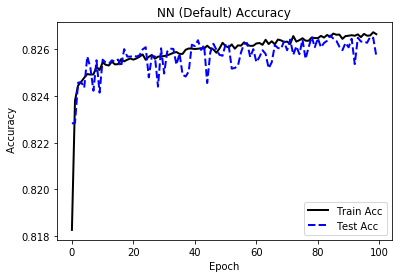

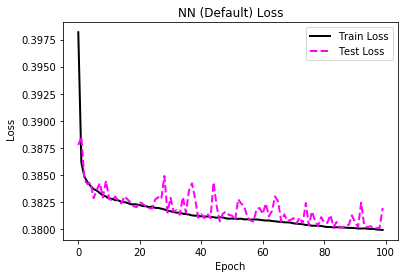

In [16]:
plot_acc_loss_vs_epoch(hist_dict_model_default, 'NN (Default)', 'nn_default', output_path, True, False)
plot_acc_loss_vs_epoch(hist_dict_model_default, 'NN (Default)', 'nn_default', output_path, False, True)

model_default acc: 82.57%


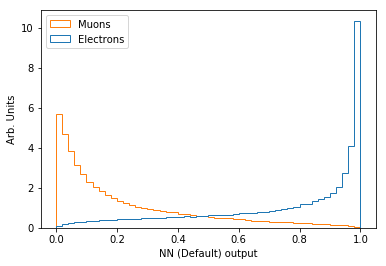

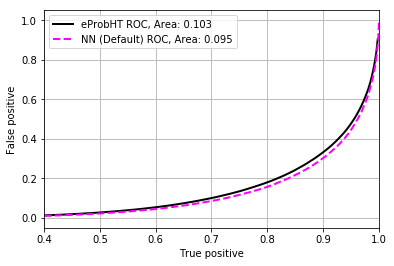

In [40]:
print("model_default %s: %.2f%%" % (model_default.metrics_names[1], model_default.evaluate(X_test,Y_test,verbose=0)[1]*100))

plot_classifier_1D_output(model_default.predict(X_test[Y_test>0.5], verbose=0), # el
                          model_default.predict(X_test[Y_test<0.5], verbose=0), # mu
                          'NN (Default)', 'nn_default', output_path
                         )

fpr_model_default, tpr_model_default, thresholds_model_default = roc_curve(Y_test, model_default.predict(X_test, verbose=0))
roc_model_default = [tpr_model_default, fpr_model_default, 'NN (Default)', 'nn_default', 'magenta', '--']

plot_roc([roc_eprob, roc_model_default], output_path)

### Wide

In [18]:
fname_model_wide = 'models/model_wide'
train_load_model_wide = train_or_load(fname_model_wide+'.h5')

Model NOT found on disk, training


In [19]:
if train_load_model_wide == 'n':
    
    # create
    model_wide = Sequential()
    model_wide.add(Dense(24, input_dim=input_ndimensions, activation='relu'))
    model_wide.add(Dense(16, activation='relu'))
    model_wide.add(Dense(1, activation='sigmoid'))

    model_wide.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train
    train_start = datetime.now()
    hist_model_wide = model_wide.fit(X_train, Y_train,
                                           epochs=100, batch_size=50,
                                           verbose=fit_verbose, validation_data=val_data);

    hist_dict_model_wide = hist_model_wide.history
    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to HDF5, history to pickle
    model_wide.save(fname_model_wide+'.h5')
   
    with open(fname_model_wide+'_hist.pickle', 'wb') as handle:
        pickle.dump(hist_dict_model_wide, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    # load model from HDF5, history from pickle
    model_wide = load_model(fname_model_wide+'.h5')
    
    with open(fname_model_wide+'_hist.pickle', 'rb') as handle:
        hist_dict_model_wide = pickle.load(handle)

Train on 1339322 samples, validate on 334831 samples
Epoch 1/100
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3917 - acc: 0.8210 - val_loss: 0.3838 - val_acc: 0.8248
Epoch 2/100
1339322/1339322 [==============================] - 30s 22us/step - loss: 0.3836 - acc: 0.8247 - val_loss: 0.3821 - val_acc: 0.8252
Epoch 3/100
1339322/1339322 [==============================] - 30s 22us/step - loss: 0.3825 - acc: 0.8252 - val_loss: 0.3871 - val_acc: 0.8219
Epoch 4/100
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3817 - acc: 0.8257 - val_loss: 0.3838 - val_acc: 0.8241
Epoch 5/100
1339322/1339322 [==============================] - 30s 22us/step - loss: 0.3812 - acc: 0.8258 - val_loss: 0.3807 - val_acc: 0.8261
Epoch 6/100
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3808 - acc: 0.8261 - val_loss: 0.3807 - val_acc: 0.8261
Epoch 7/100
1339322/1339322 [==============================] - 30s 22us/step - loss: 0.38

1339322/1339322 [==============================] - 30s 22us/step - loss: 0.3777 - acc: 0.8277 - val_loss: 0.3782 - val_acc: 0.8275
Epoch 58/100
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3776 - acc: 0.8277 - val_loss: 0.3786 - val_acc: 0.8274
Epoch 59/100
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3776 - acc: 0.8278 - val_loss: 0.3790 - val_acc: 0.8269
Epoch 60/100
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3776 - acc: 0.8278 - val_loss: 0.3794 - val_acc: 0.8269
Epoch 61/100
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3776 - acc: 0.8278 - val_loss: 0.3801 - val_acc: 0.8266
Epoch 62/100
1339322/1339322 [==============================] - 30s 22us/step - loss: 0.3776 - acc: 0.8277 - val_loss: 0.3782 - val_acc: 0.8278
Epoch 63/100
1339322/1339322 [==============================] - 30s 23us/step - loss: 0.3776 - acc: 0.8279 - val_loss: 0.3778 - val_acc: 0.8276
Epoch

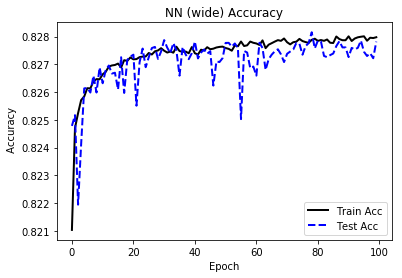

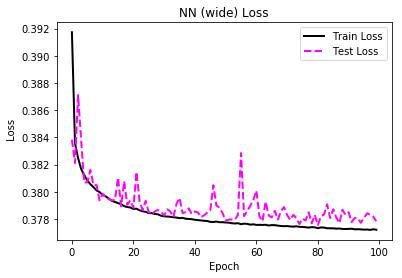

In [20]:
plot_acc_loss_vs_epoch(hist_dict_model_wide, 'NN (wide)', 'nn_wide', output_path, True, False)
plot_acc_loss_vs_epoch(hist_dict_model_wide, 'NN (wide)', 'nn_wide', output_path, False, True)

model_wide acc: 82.78%


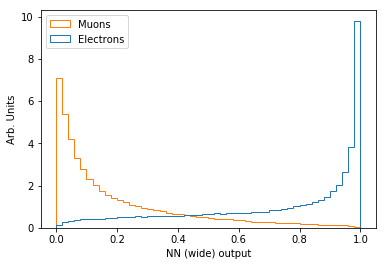

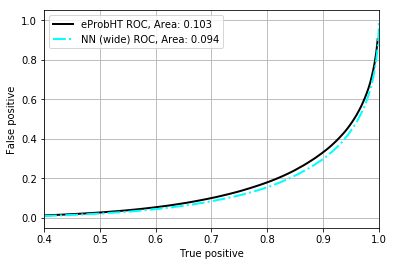

In [41]:
print("model_wide %s: %.2f%%" % (model_wide.metrics_names[1], model_wide.evaluate(X_test,Y_test,verbose=0)[1]*100))

plot_classifier_1D_output(model_wide.predict(X_test[Y_test>0.5], verbose=0), # el
                          model_wide.predict(X_test[Y_test<0.5], verbose=0), # mu
                          'NN (wide)', 'nn_wide', output_path
                         )

fpr_model_wide, tpr_model_wide, thresholds_model_wide = roc_curve(Y_test, model_wide.predict(X_test, verbose=0))
roc_model_wide = [tpr_model_wide, fpr_model_wide, 'NN (wide)', 'nn_wide', 'cyan', '-.']

plot_roc([roc_eprob, roc_model_wide], output_path)

### Deep

In [22]:
fname_model_deep = 'models/model_deep'
train_load_model_deep = train_or_load(fname_model_deep+'.h5')

Model NOT found on disk, training


In [23]:
if train_load_model_deep == 'n':
    
    # create
    model_deep = Sequential()
    model_deep.add(Dense(12, input_dim=input_ndimensions, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(1, activation='sigmoid'))

    model_deep.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train
    train_start = datetime.now()
    hist_model_deep = model_deep.fit(X_train, Y_train,
                                           epochs=100, batch_size=50,
                                           verbose=fit_verbose, validation_data=val_data);

    hist_dict_model_deep = hist_model_deep.history
    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to HDF5, history to pickle
    model_deep.save(fname_model_deep+'.h5')
   
    with open(fname_model_deep+'_hist.pickle', 'wb') as handle:
        pickle.dump(hist_dict_model_deep, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    # load model from HDF5, history from pickle
    model_deep = load_model(fname_model_deep+'.h5')
    
    with open(fname_model_deep+'_hist.pickle', 'rb') as handle:
        hist_dict_model_deep = pickle.load(handle)

Train on 1339322 samples, validate on 334831 samples
Epoch 1/100
1339322/1339322 [==============================] - 33s 25us/step - loss: 0.3933 - acc: 0.8202 - val_loss: 0.3839 - val_acc: 0.8247
Epoch 2/100
1339322/1339322 [==============================] - 33s 25us/step - loss: 0.3858 - acc: 0.8240 - val_loss: 0.3852 - val_acc: 0.8248
Epoch 3/100
1339322/1339322 [==============================] - 33s 25us/step - loss: 0.3845 - acc: 0.8245 - val_loss: 0.3836 - val_acc: 0.8250
Epoch 4/100
1339322/1339322 [==============================] - 33s 25us/step - loss: 0.3837 - acc: 0.8252 - val_loss: 0.3853 - val_acc: 0.8241
Epoch 5/100
1339322/1339322 [==============================] - 33s 25us/step - loss: 0.3832 - acc: 0.8252 - val_loss: 0.3887 - val_acc: 0.8213
Epoch 6/100
1339322/1339322 [==============================] - 33s 25us/step - loss: 0.3828 - acc: 0.8254 - val_loss: 0.3814 - val_acc: 0.8261
Epoch 7/100
1339322/1339322 [==============================] - 32s 24us/step - loss: 0.38

1339322/1339322 [==============================] - 39s 29us/step - loss: 0.3798 - acc: 0.8267 - val_loss: 0.3797 - val_acc: 0.8265
Epoch 58/100
1339322/1339322 [==============================] - 39s 29us/step - loss: 0.3798 - acc: 0.8265 - val_loss: 0.3813 - val_acc: 0.8260
Epoch 59/100
1339322/1339322 [==============================] - 39s 29us/step - loss: 0.3798 - acc: 0.8266 - val_loss: 0.3802 - val_acc: 0.8264
Epoch 60/100
1339322/1339322 [==============================] - 36s 27us/step - loss: 0.3798 - acc: 0.8268 - val_loss: 0.3810 - val_acc: 0.8252
Epoch 61/100
1339322/1339322 [==============================] - 35s 26us/step - loss: 0.3797 - acc: 0.8266 - val_loss: 0.3799 - val_acc: 0.8267
Epoch 62/100
1339322/1339322 [==============================] - 38s 28us/step - loss: 0.3797 - acc: 0.8268 - val_loss: 0.3796 - val_acc: 0.8267
Epoch 63/100
1339322/1339322 [==============================] - 34s 25us/step - loss: 0.3797 - acc: 0.8267 - val_loss: 0.3802 - val_acc: 0.8263
Epoch

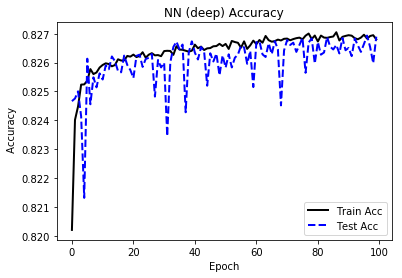

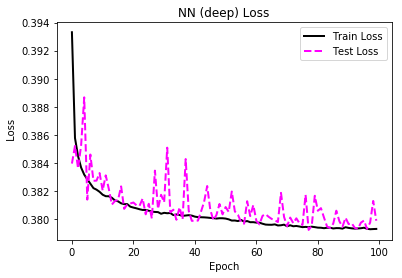

In [24]:
plot_acc_loss_vs_epoch(hist_dict_model_deep, 'NN (deep)', 'nn_deep', output_path, True, False)
plot_acc_loss_vs_epoch(hist_dict_model_deep, 'NN (deep)', 'nn_deep', output_path, False, True)

model_deep acc: 82.69%


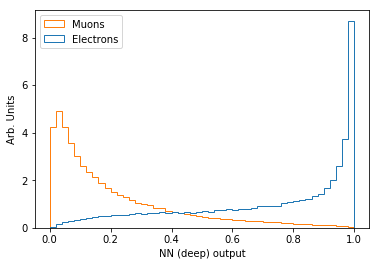

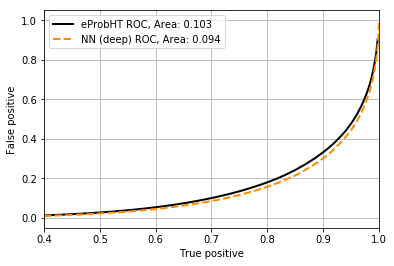

In [42]:
print("model_deep %s: %.2f%%" % (model_deep.metrics_names[1], model_deep.evaluate(X_test,Y_test,verbose=0)[1]*100))

plot_classifier_1D_output(model_deep.predict(X_test[Y_test>0.5], verbose=0), # el
                          model_deep.predict(X_test[Y_test<0.5], verbose=0), # mu
                          'NN (deep)', 'nn_deep', output_path
                         )

fpr_model_deep, tpr_model_deep, thresholds_model_deep = roc_curve(Y_test, model_deep.predict(X_test, verbose=0))
roc_model_deep = [tpr_model_deep, fpr_model_deep, 'NN (deep)', 'nn_deep', 'darkorange', '--']

plot_roc([roc_eprob, roc_model_deep], output_path)

### Compare all models

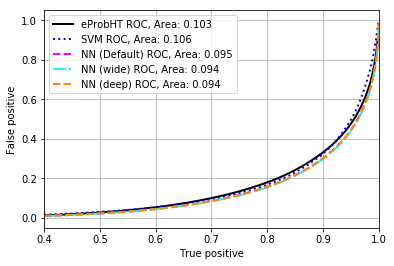

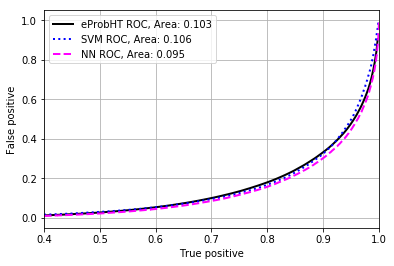

In [32]:
all_models = []
all_models.append(roc_eprob)
all_models.append(roc_svm1)
all_models.append(roc_model_default)
all_models.append(roc_model_wide)
all_models.append(roc_model_deep)

plot_roc(all_models, output_path)

roc_model_default_clean = list(roc_model_default)
roc_model_default_clean[2] = 'NN'
roc_model_default_clean[3] += '_clean'
plot_roc([roc_eprob, roc_svm1, roc_model_default_clean], output_path)

In [27]:
print("Total elapsed time: %s" % (strfdelta(datetime.now()-time_all_start, "{hours} hours, {minutes} minutes, {seconds} seconds")))

Total elapsed time: 2 hours, 50 minutes, 31 seconds
